
# How to use CutMix and MixUp

<div class="alert alert-info"><h4>Note</h4><p>Try on [Colab](https://colab.research.google.com/github/pytorch/vision/blob/gh-pages/main/_generated_ipynb_notebooks/plot_cutmix_mixup.ipynb)
    or `go to the end <sphx_glr_download_auto_examples_transforms_plot_cutmix_mixup.py>` to download the full example code.</p></div>

:class:`~torchvision.transforms.v2.CutMix` and
:class:`~torchvision.transforms.v2.MixUp` are popular augmentation strategies
that can improve classification accuracy.

These transforms are slightly different from the rest of the Torchvision
transforms, because they expect
**batches** of samples as input, not individual images. In this example we'll
explain how to use them: after the ``DataLoader``, or as part of a collation
function.


In [1]:
import torch
from torchvision.datasets import FakeData
from torchvision.transforms import v2
import sys


NUM_CLASSES = 100

In [2]:

sys.path.append("/home/gheorghe/Desktop/AI/manager/imshow")

def remove_modules(modules_name, *arg):
    if (modules_name in sys.modules):
        del sys.modules[modules_name]
        for key in arg:
            tmp_modules = "{}.{}".format(modules_name, key)
            del sys.modules[tmp_modules]
            
remove_modules("plot_image")
from plot_image import *

In [3]:

def unpack_img(data):
    #print("type {}, min {}, max {}, shape {}".format(type(data), torch.min(data), torch.max(data), data.shape))
    data = data.detach().cpu().numpy()
    img = np.transpose(data, (1, 2, 0))
    return img
plot_img = PlotsImage(unpack_fn=unpack_img)

## Pre-processing pipeline

We'll use a simple but typical image classification pipeline:



In [5]:
preproc = v2.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True), 
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # typically from ImageNet
])

dataset = FakeData(size=1000, num_classes=NUM_CLASSES, transform=preproc)

img, label = dataset[0]
print(f"{type(img) = }, {img.dtype = }, {img.shape = }, {label = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.float32, img.shape = torch.Size([3, 224, 224]), label = 67


One important thing to note is that neither CutMix nor MixUp are part of this
pre-processing pipeline. We'll add them a bit later once we define the
DataLoader. Just as a refresher, this is what the DataLoader and training loop
would look like if we weren't using CutMix or MixUp:



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.605142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.605142].


images.shape = torch.Size([4, 3, 224, 224]), labels.shape = torch.Size([4]), labels = tensor([15, 60, 88, 42])
torch.int64


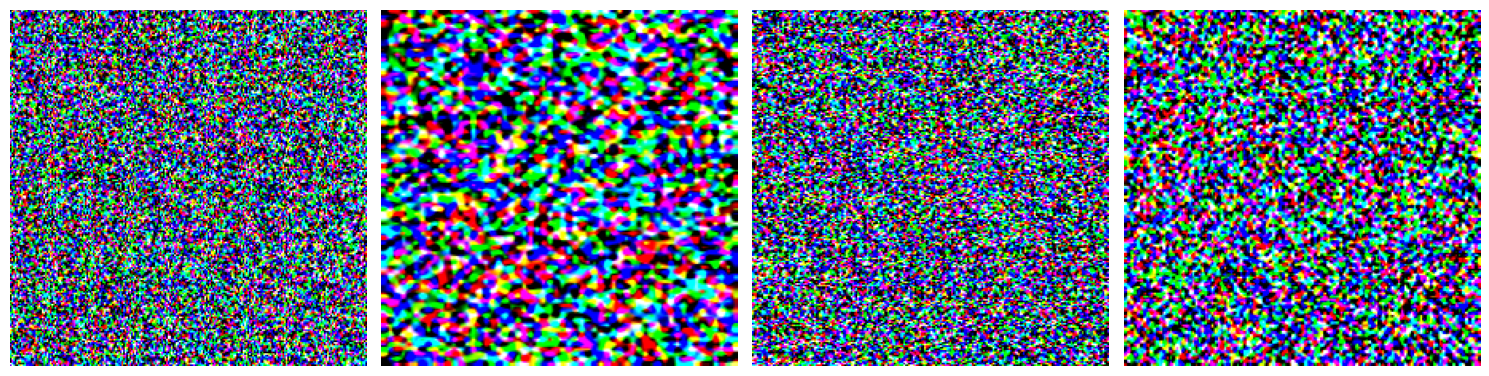

In [6]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for images, labels in dataloader:
    print(f"{images.shape = }, {labels.shape = }, {labels = }")
    print(labels.dtype)
    plot_img(images)
    # <rest of the training loop here>
    break

## Where to use MixUp and CutMix

### After the DataLoader

Now let's add CutMix and MixUp. The simplest way to do this right after the
DataLoader: the Dataloader has already batched the images and labels for us,
and this is exactly what these transforms expect as input:



/tmp/ipykernel_274852/1495584405.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = np.array(labels)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.605142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.605142].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5702837].


Before CutMix/MixUp: images.shape = torch.Size([4, 3, 224, 224]), labels.shape = torch.Size([4]), labels = tensor([ 5, 29, 21, 16])
After CutMix/MixUp: images.shape = torch.Size([4, 3, 224, 224]), labels.shape = (2, 2), labels = array([[ 5, 29],
       [21, 16]])


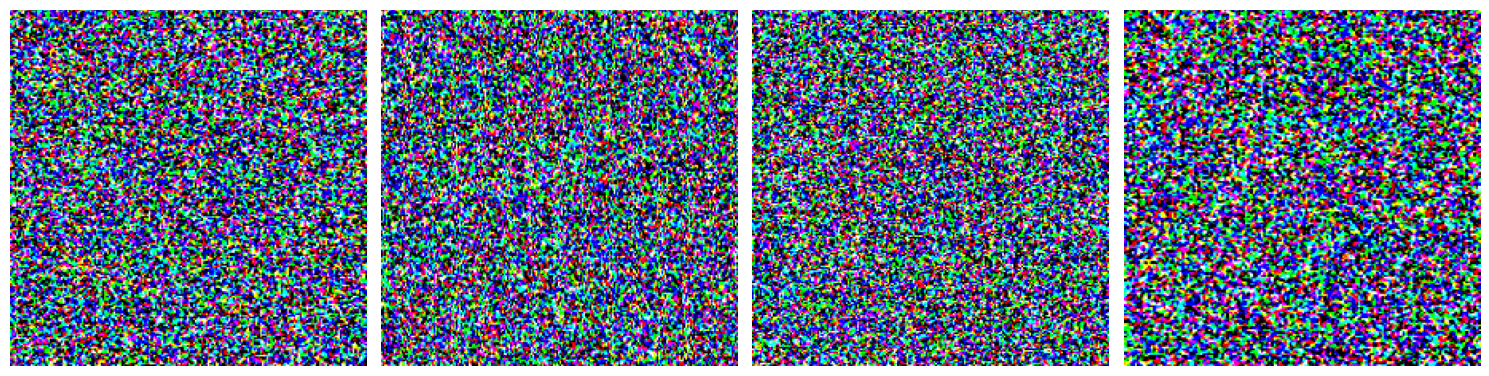

In [14]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
identity = v2.Identity()
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup, identity])

for images, labels in dataloader:
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }, {labels = }")
    images, labels = cutmix_or_mixup(images, labels)
    labels = np.array(labels)
    labels = labels[labels>0].reshape(-1, 2)
    print(f"After CutMix/MixUp: {images.shape = }, {labels.shape = }, {labels = }")

    plot_img(images)
    # <rest of the training loop here>
    break

In [ ]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

cutmix = v2.CutMix(num_classes=NUM_CLASSES)

for images, labels in dataloader:
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }, {labels = }")
    images, labels = cutmix(images, labels)
    labels = np.array(labels)
    labels = labels[labels>0].reshape(-1, 2)
    print(f"After CutMix/MixUp: {images.shape = }, {labels.shape = }, {labels = }")

    plot_img(images)
    # <rest of the training loop here>
    break

In [ ]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

mixup = v2.MixUp(num_classes=NUM_CLASSES)

for images, labels in dataloader:
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }, {labels = }")
    images, labels = mixup(images, labels)
    labels = np.array(labels)
    labels = labels[labels>0].reshape(-1, 2)
    print(f"After CutMix/MixUp: {images.shape = }, {labels.shape = }, {labels = }")

    plot_img(images)
    # <rest of the training loop here>
    break

Note how the labels were also transformed: we went from a batched label of
shape (batch_size,) to a tensor of shape (batch_size, num_classes). The
transformed labels can still be passed as-is to a loss function like
:func:`torch.nn.functional.cross_entropy`.

### As part of the collation function

Passing the transforms after the DataLoader is the simplest way to use CutMix
and MixUp, but one disadvantage is that it does not take advantage of the
DataLoader multi-processing. For that, we can pass those transforms as part of
the collation function (refer to the [PyTorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) to learn
more about collation).



In [ ]:
from torch.utils.data import default_collate


def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))


dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

for images, labels in dataloader:
    labels = np.array(labels)
    labels = labels[labels>0].reshape(-1, 2)
    print(f"{images.shape = }, {labels.shape = }, {labels = }")
    # No need to call cutmix_or_mixup, it's already been called as part of the DataLoader!
    # <rest of the training loop here>
    break

## Non-standard input format

So far we've used a typical sample structure where we pass ``(images,
labels)`` as inputs. MixUp and CutMix will magically work by default with most
common sample structures: tuples where the second parameter is a tensor label,
or dict with a "label[s]" key. Look at the documentation of the
``labels_getter`` parameter for more details.

If your samples have a different structure, you can still use CutMix and MixUp
by passing a callable to the ``labels_getter`` parameter. For example:



In [ ]:
batch = {
    "imgs": torch.rand(4, 3, 224, 224),
    "target": {
        "classes": torch.randint(0, NUM_CLASSES, size=(4,)),
        "some_other_key": "this is going to be passed-through"
    }
}


def labels_getter(batch):
    return batch["target"]["classes"]


out = v2.CutMix(num_classes=NUM_CLASSES, labels_getter=labels_getter)(batch)
print(f"{out['imgs'].shape = }, {out['target']['classes'].shape = }")